In [1]:
import numpy as np
import h5py
import lmdb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
from PIL import Image
from bs4 import BeautifulSoup
import requests
import re
import os
import glob
import pathlib
import time
import datetime
import json
import pprint
from ip_basic import depth_map_utils
# for nyu, tum, diode
def center_crop(im, new_width=None, new_height=None):
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return im.crop((left, top, right, bottom))
def show_example(path='/hy-tmp/stage1/rgb_depth_large.mat', idx=0):
    with  h5py.File(path,'r') as t:
        rgb = t['rgb']
        depth = t['depth']
        print(rgb.shape)
        rgbi = rgb[idx]
        depthi = depth[idx]
    fig=plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    xx = np.arange(0,256)
    yy = np.arange(0,256)
    X, Y = np.meshgrid(xx, yy)
    ax1.plot_surface(X,Y,depthi.squeeze(),cmap='rainbow')
    plt.show()
    plt.close()

    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(rgbi)
    ax2.imshow(depthi)
    plt.show()
    plt.close()
# for tum
def depth_completion(depthi, loop=2):
    '''ip_basic depth completion
    '''
    fill_type = 'fast'
    extrapolate = True
    blur_type = 'bilateral'
    for _ in range(loop):
        if fill_type == 'fast':
            depthi = depth_map_utils.fill_in_fast(
                depthi, extrapolate=extrapolate, blur_type=blur_type)
        elif fill_type == 'multiscale':
            depthi, process_dict = depth_map_utils.fill_in_multiscale(
                depthi, extrapolate=extrapolate, blur_type=blur_type,
                show_process=False)
    return depthi
def get_timestamp(v):
    f = v.split("/")[-1]
    stamp = f.replace(".png","")
    return float(stamp)
def align_rgb_depth(rgbs, depths, bi=True):
    '''Align two sequeces by timestamps in the filenames
    Use rgb as base
    '''
    if len(rgbs)==len(depths):
        return rgbs, depths
    res_rgbs = rgbs
    res_depths = []
    for i, v in enumerate(res_rgbs):
        target_stamp = get_timestamp(v)
        current_d = depths[0]
        if bi:
            # bi-search
            left = 0
            right = len(depths)-1
            while left<=right:
                mid = (left+right)//2
                now_stamp = get_timestamp(depths[mid])
                if now_stamp==target_stamp:
                    left=mid
                    right=mid-1
                elif now_stamp>target_stamp:
                    right = mid-1
                else:
                    left = mid+1
            if left==0:
                current_d = depths[left]
            elif right==len(depths)-1:
                current_d = depths[right]
            else:
                current_d = depths[left] if abs(get_timestamp(depths[left])-target_stamp)<abs(get_timestamp(depths[left-1])-target_stamp) else depths[left-1]
        else:
            current_min = 100000000
            for j, p in enumerate(depths):
                current_stamp = get_timestamp(p)
                if abs(target_stamp-current_stamp)<current_min:
                    current_min =  abs(target_stamp-current_stamp)
                    current_d = p
        res_depths.append(current_d)
    assert len(res_rgbs)==len(res_depths)
    return res_rgbs, res_depths

## Split episode and panorama

In [5]:
# Adapted from https://github.com/fuenwang/Equirec2Perspec

import os
import sys
import cv2
import numpy as np
import math

class Equirectangular:
    def __init__(self, img):
        self._img = img
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    

    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS = 128):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0     
        
        hFOV = math.radians(FOV)
        wFOV = 2*math.atan(float(width)/height * np.tan(hFOV / 2.0))

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (math.pi - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(wFOV / 2.0) / np.sin(wangle)
        w_interval = w_len / (width - 1)

        hangle = (math.pi - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(hFOV / 2.0) / np.sin(hangle)
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], np.float32) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)
        
        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        #for x in range(width):
        #    for y in range(height):
        #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
        #return self._img 
    
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

"""从全景图得到子图的代码"""
# Simulator image parameters
VIEWPOINT_SIZE = 36
FEATURE_SIZE = 2048

# WIDTH = 480
# HEIGHT = 480
# VFOV = 90
# HFOV = 90  # makes a VFOV of 60

def equirectangular_to_perspective(image, save_path, viewpoint):
    ''' Convert an equirectangular pano to 36 perspective images used by the VLN
        agent. Construct it with 12 heading 
        viewpoints and 3 elevation viewpoints, starting with the heading that is
        directly in front. The agent works better if these views are aligned to the
        building. '''
    equi = Equirectangular(image)  # RGB shape of [H, W, 3]
    im_width = 224
    im_height = 224
    vfov = 90

    # heading, elevation. Here, heading is defined from the x-axis, and turning right 
    # is positive. This matches the matterport sim, but opposite to ros
    he = np.zeros((3, 12, 2), dtype=np.float32)

    
    # for i,v_deg in enumerate(range(0, 30, 30)):
        # 注意！ 这个-150°是和全景图在MP3D模拟器中的航向角挂钩的，MP3D中的航向角=150 - ros_heading
    v_deg = 0
    i = 0
    for j,u_deg in enumerate(range(-180, 180, 90)):
        # Negate heading since for e2p turning right is positive, opposite in ros
        head = -math.radians(u_deg)
        he[i,j] = [head + 2*math.pi if head<0 else head, math.radians(v_deg)]
        p_im = equi.GetPerspective(vfov, u_deg, v_deg, im_height, im_width)
        cv2.imwrite(os.path.join(save_path, f"{viewpoint}_{str(12*i+j)}.jpg"), p_im)
           
def roll_image(image, pano_heading_rad):
    """
    input: 
        image: theta相机获得的全景图,机器人坐标系
        pano_heading_rad: 机器人朝向
    output:
        image: 将全景图转到地图坐标系0方向
    """
    x_axis = 1 # width
    roll_pixels = -int(pano_heading_rad / (math.pi * 2) * image.shape[x_axis])
    rolled_image = np.roll(image, roll_pixels, axis=x_axis)
    return rolled_image           

In [6]:
raw_data_path = "/root/autodl-tmp/r2r/"
dataset_path = "/root/autodl-tmp/r2r/tjark_r2r_all.json"
new_data_path = "/root/autodl-tmp/r2r_split/"
os.makedirs(new_data_path, exist_ok=True)
with open(dataset_path, "r") as f:
    tjark_r2r = json.loads(f.read())
for i, ep in tqdm(enumerate(tjark_r2r)):
    scan = ep["scan"]+"_imgs"
    path = ep["path"]
    inst = ep["instructions"][0]

    os.makedirs(os.path.join(new_data_path, str(i)), exist_ok=True)
    inst_path = os.path.join(new_data_path, str(i), "instruction.txt")
    with open(inst_path,"w") as f:
        f.write(inst)

    for j,vp in enumerate(path):
        img_path = os.path.join(raw_data_path, scan, vp+"_equirectangular.jpg")
        img = cv2.imread(img_path)
        os.makedirs(os.path.join(new_data_path, str(i), "rgb"), exist_ok=True)
        equirectangular_to_perspective(img, os.path.join(new_data_path, str(i), "rgb"), j)

0it [00:00, ?it/s]

In [ ]:
ep

## Depth estimation

In [2]:

# timm==0.6.7
# 
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch

from torchvision import transforms

import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

resize = transforms.Resize([384, 512])
scale = 4.0

test_image = 'C:/Users/tangjg/Desktop/08c774f20c984008882da2b8547850eb_skybox1_sami.jpg'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")


def load_model():
    # torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True) 
    model = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True)
    model.to(DEVICE)
    model.eval()
    return model

def InferImage(image_file):
    image = Image.open(image_file)
    origin_size = image.size
    img = ToTensor()(image).to(DEVICE).unsqueeze_(0)
    img.to(DEVICE)
    
    model = load_model()
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        out = model(img)
        out_img = Image.fromarray(out['metric_depth'].squeeze().cpu().numpy())
        out_img.resize(origin_size, Image.ANTIALIAS)
        out_img.show()

model = load_model()
def inferImageAndCompare(idx, model):
    rgb_path = f'/root/autodl-tmp/r2r_split/{idx}/rgb'
    out_path = f'/root/autodl-tmp/r2r_split/{idx}/depth'
    os.makedirs(out_path, exist_ok=True)

    rgb_images = os.listdir(rgb_path)
    for rgb_img in rgb_images:
        path = os.path.join(rgb_path, rgb_img)
        
        image = Image.open(path)
        origin_size = image.size
        origin_max = np.array(image).max()
        
        depth_pil = model.infer_pil(image, output_type='pil')
        
        # resize并进行scale缩放，与GT尺度相同
        depth_pil = depth_pil.resize(origin_size, Image.LANCZOS)
        out_arr = np.array(depth_pil)
        out_arr = out_arr*scale # multiplied by 4, assume it is accurate absolute depth*1000
        depth_pil = Image.fromarray(out_arr.astype(np.uint16))
        
        depth_pil.save(os.path.join(out_path, rgb_img.replace(".jpg",".png")))
for i in tqdm(range(408)):
    inferImageAndCompare(i, model)

Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


  0%|          | 0/408 [00:00<?, ?it/s]

## To dataset

In [3]:
import copy
import gzip
import itertools
import json
import pickle
import random
import re
import threading
import time
from collections import Counter
import glob

import h5py
import clip
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from nltk.tokenize import PunktSentenceTokenizer
from numba import jit
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import pathlib
from nltk.tokenize import PunktSentenceTokenizer
random.seed(25)
np.random.seed(25)
def instruction_cut_clip(episodes, append_dot=False, keep_subs=True, refine=False, split_func=None, lower_all=False):
    """
    Params:
        episodes: a dataset list, [{"instruction_text":""}]
        append_dot: whether to add a "." at the end of sub-instructions
        keep_subs: whether to keep sub-instruction text after processing
        refine: whether to use proposed refine processing
        split_func: the function used to cut instructions, default is `nltk.sent_tokenize`
        lower_all: whether to lower all characters in sub-instructions.
    Return:
        train_data with "sub_instruction_tokens" and "sub_instruction"
    """
    if split_func is None:
        split_func = nltk.sent_tokenize
    print(split_func)
    train_data = copy.deepcopy(episodes)
    # pre process
    char_pattern = re.compile(r"[a-zA-Z]")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        inst = inst.strip()
        start_idx = 0
        while not char_pattern.search(inst[start_idx]):
            start_idx += 1
        inst = inst[start_idx:]
        if lower_all:
            inst = inst.lower()
        train_data[i]["instruction_text"] = inst.replace("...", ".").replace("..", ".").replace(".",". ").replace("  ", " ")
    
    # cut by nltk
    pattern = re.compile(r"\r\n")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        res = []
        now = pattern.split(inst)
        for v in now:
            res.extend(split_func(v))
        train_data[i]["sub_instruction"] = [piece.strip() for piece in res if piece.strip()]
    # refine
    if refine:
        punctuation_list = [",", "."]
        char_pattern = re.compile(r"[a-zA-Z]+")
        def judge_verb(word):
            const_verbs = ["wait", "turn", "walk", "stop"]
            if "VB" in word[1]:
                return True
            if word[0] in const_verbs:
                return True
            return False
        for i, item in enumerate(tqdm(train_data)):
            new_sub = []
            for k, piece in enumerate(item["sub_instruction"]):
                word_list = nltk.pos_tag(nltk.word_tokenize(piece))
                tmp = ""
                for x, word in enumerate(word_list):
                    if (word[0].lower()=="and" or word[0]=="," or word[0].lower()=="then") and (x+1<len(word_list) and judge_verb(word_list[x+1])):
                        if tmp and char_pattern.search(tmp):
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                            
                    elif (word[0]=="and" or word[0]==",") and (x+1<len(word_list) and word_list[x+1][0]=="then"):
                        if tmp:
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                    else:
                        if not tmp or word[0] in punctuation_list:
                            tmp+=word[0]
                        else:
                            tmp+=(" "+word[0])
                if tmp:
                    new_sub.append(tmp)
            train_data[i]["sub_instruction"] = new_sub
    
    # post process and generate tokens
    char_pattern = re.compile(r"[a-zA-Z]")
    max_len = 0
    pad_index = 0
    pad_len = 86 # 0.09%
    sub_pad_len = 77 # 0.05%
    sub_num = 12 # 0.04%
    useless_sub = [pad_index]*sub_pad_len
    sub_split_index = -1
    for i, item in enumerate(tqdm(train_data)):
        tokens_all = []
        tokens_split = []
        for k, piece in enumerate(item["sub_instruction"]):
            piece = piece.strip()
            assert piece
            idx = len(piece)-1
            while idx>=0 and piece[idx] in [".", ","]:
                idx -= 1
            if append_dot:
                piece = piece[0:(idx+1)]+"."
            else:
                piece = piece[0:(idx+1)]
            piece = piece.replace("``", "\"").replace("''", "\"")
            train_data[i]["sub_instruction"][k] = piece
            # piece_tokens = clip.tokenize(piece, truncate=True).squeeze(0).tolist()
            # tokens_split.append(piece_tokens)
        # if len(tokens_split)>sub_num:
        #     tokens_split = tokens_split[0:sub_num]
        # tokens_split.extend([useless_sub]*(sub_num-len(tokens_split)))
        
        # train_data[i]["instruction_tokens"] = clip.tokenize(item["instruction_text"], truncate=True, context_length=77).squeeze(0).tolist()
        # train_data[i]["sub_instruction_tokens"] = tokens_split
        if not keep_subs:
            del item["sub_instruction"]
    return train_data

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
def random_chunks(lst, left, right):
    """Yield successive n-sized chunks from lst."""
    i = 0
    n = len(lst)
    while i<n:
        k = random.randint(left,right)
        yield lst[i:min(i+k, n)]
        i += k

In [4]:

MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 768
RGB_SIZE = 224
DEPTH_SIZE = 224
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
os.makedirs("/root/autodl-tmp/realscene", exist_ok=True)
real_folder = "/root/autodl-tmp/realscene"

rgbs = []
depths = []
insts = []
subs = []
for ep_id in range(408):
    episode_folder = "/root/autodl-tmp/r2r_split/{}".format(ep_id)
    with open(os.path.join(episode_folder, "instruction.txt"), "r") as f:
        inst = f.read()
    rgbs.extend(sorted(glob.glob(os.path.join(episode_folder, "rgb","*"))))
    depths.extend(sorted(glob.glob(os.path.join(episode_folder, "depth","*"))))
    assert len(rgbs)==len(depths)
    insts.extend([inst]*len(sorted(glob.glob(os.path.join(episode_folder, "rgb","*")))))
instructions = [{"instruction_text": v} for v in insts]
sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=nltk.sent_tokenize, keep_subs=True)
assert len(instructions)==len(sub_data)
assert len(instructions)==len(rgbs)

train_num = len(rgbs)//2
train_indicies = random.sample(list(range(len(rgbs))), train_num)

<function sent_tokenize at 0x7f04992ac550>


  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

In [8]:
# train
from pathlib import Path
import shutil
FOLDER_RGB_OUT = Path("/root/autodl-tmp/realscene/rgb-vlntj/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/realscene/depth-vlntj/train")
FOLDER_INST_OUT = Path("/root/autodl-tmp/realscene/text-vlntj/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/realscene/sub-vlntj/train")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)

for i in train_indicies:
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    inst_path = FOLDER_INST_OUT / "{}.txt".format(i)
    sub_path = FOLDER_SUB_OUT / "{}.txt".format(i)

    old_rgb_path = rgbs[i]
    old_depth_path = depths[i]
    shutil.copy(old_rgb_path, rgb_path)
    shutil.copy(old_depth_path, depth_path)
    with open(inst_path, "w") as f:
        f.write(sub_data[i]["instruction_text"])
    with open(sub_path, "w") as f:
        f.write("\n".join(sub_data[i]["sub_instruction"]))

# val
from pathlib import Path
FOLDER_RGB_OUT = Path("/root/autodl-tmp/realscene/rgb-vlntj/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/realscene/depth-vlntj/val")
FOLDER_INST_OUT = Path("/root/autodl-tmp/realscene/text-vlntj/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/realscene/sub-vlntj/val")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)

for i in range(len(rgbs)):
    if i not in train_indicies:
        rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
        depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
        inst_path = FOLDER_INST_OUT / "{}.txt".format(i)
        sub_path = FOLDER_SUB_OUT / "{}.txt".format(i)

        old_rgb_path = rgbs[i]
        old_depth_path = depths[i]
        shutil.copy(old_rgb_path, rgb_path)
        shutil.copy(old_depth_path, depth_path)
        with open(inst_path, "w") as f:
            f.write(sub_data[i]["instruction_text"])
        with open(sub_path, "w") as f:
            f.write("\n".join(sub_data[i]["sub_instruction"]))

4386
==========3316==========
inst: Turn left, go straight along the corridor, pass an open conference room door and intersection, and stop at the next meeting door. 
sub: Turn left
go straight along the corridor
pass an open conference room door and intersection
and stop at the next meeting door
/root/autodl-tmp/realscene/rgb-vlntj/val/6943.jpg /root/autodl-tmp/realscene/depth-vlntj/val/6943.png


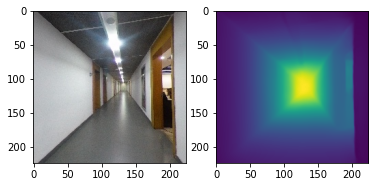

==========2497==========
inst: Turn right and go straight along the gallery. Go right in front of the red alarm. Go ahead and turn left when you enter the corridor. Enter the first open door and walk between the green cabinet and the wall. Then turn right to the reading table in the library and stop. 
sub: Turn right
and go straight along the gallery
Go right in front of the red alarm
Go ahead
and turn left when you enter the corridor
Enter the first open door
and walk between the green cabinet and the wall
Then turn right to the reading table in the library
and stop
/root/autodl-tmp/realscene/rgb-vlntj/val/5436.jpg /root/autodl-tmp/realscene/depth-vlntj/val/5436.png


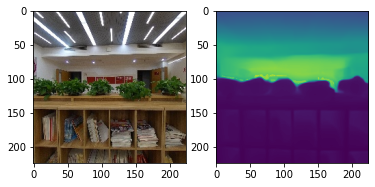

==========1184==========
inst: Turn left and go straight along the corridor until you come to the front door of the conference room, turn right into the conference room and stop. 
sub: Turn left
and go straight along the corridor until you come to the front door of the conference room
turn right into the conference room
and stop
/root/autodl-tmp/realscene/rgb-vlntj/val/3144.jpg /root/autodl-tmp/realscene/depth-vlntj/val/3144.png


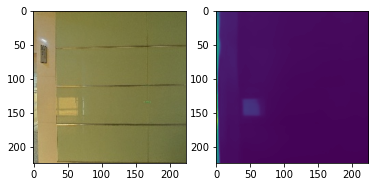

==========796==========
inst: Leave the room through the nearest door, then turn left in the hallway, enter the second room and wait at the door. 
sub: Leave the room through the nearest door
then turn left in the hallway
enter the second room
and wait at the door
/root/autodl-tmp/realscene/rgb-vlntj/val/2464.jpg /root/autodl-tmp/realscene/depth-vlntj/val/2464.png


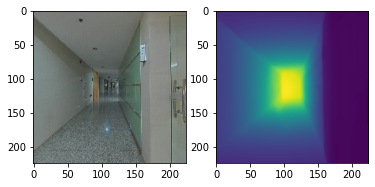

==========755==========
inst: You are at the door of the storeroom. First you need to go through the glass door and get out of the pantry. You can see two black chairs facing each other in the corridor. Then walk away from the two black chairs and you will pass a cardboard box. Then continue in this direction and you will pass an overturned blue cart. Keep walking in this way and you will pass the restaurant door and you will see a black chair facing you on the right. You will see the door of the conference room immediately after passing the black chair. You need to turn left into the conference room and stop at the door. 
sub: You are at the door of the storeroom
First you need to go through the glass door
and get out of the pantry
You can see two black chairs facing each other in the corridor
Then walk away from the two black chairs and you will pass a cardboard box
Then continue in this direction and you will pass an overturned blue cart
Keep walking in this way and you will pass th

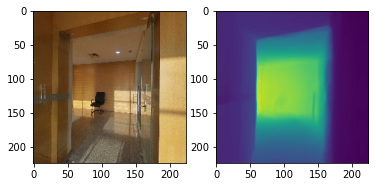

==========405==========
inst: In front of you is a conference room, you can see basketball and tennis racquet placed on a table against the wall, first step back, exit the conference room, through the glass door, turn right, see a corridor, corridor has a black chair on the right, after the chair, you will see the entrance to the dining room, turn left into the dining room, see the electric gate and air conditioning switch on the left wall and stop
sub: In front of you is a conference room, you can see basketball and tennis racquet placed on a table against the wall, first step back, exit the conference room, through the glass door
turn right
see a corridor, corridor has a black chair on the right, after the chair, you will see the entrance to the dining room
turn left into the dining room
see the electric gate and air conditioning switch on the left wall
and stop
/root/autodl-tmp/realscene/rgb-vlntj/val/1742.jpg /root/autodl-tmp/realscene/depth-vlntj/val/1742.png


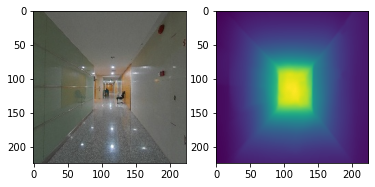

==========4089==========
inst: Turn left, go ahead and pass the fire hydrant and the door of the conference room. Go ahead at the intersection until you see the door of the library and stop when you enter the library. 
sub: Turn left
go ahead
and pass the fire hydrant and the door of the conference room
Go ahead at the intersection until you see the door of the library
and stop when you enter the library
/root/autodl-tmp/realscene/rgb-vlntj/val/8324.jpg /root/autodl-tmp/realscene/depth-vlntj/val/8324.png


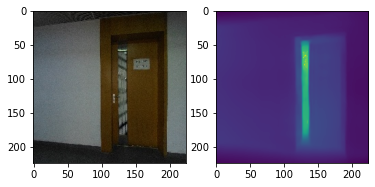

==========3232==========
inst: Go straight along the corridor to the left, pass the fire hydrant and an open door, and stop at the intersection. 
sub: Go straight along the corridor to the left
pass the fire hydrant and an open door
and stop at the intersection
/root/autodl-tmp/realscene/rgb-vlntj/val/6771.jpg /root/autodl-tmp/realscene/depth-vlntj/val/6771.png


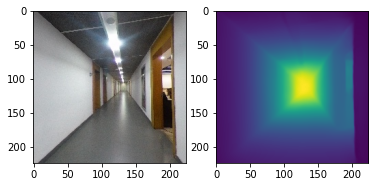

==========326==========
inst: Turn around, pass a red basketball and a black chair with a baseball bat and baseball on the right, turn left by the white trash can, go straight to a chair with white clothes, and stop. 
sub: Turn around, pass a red basketball and a black chair with a baseball bat and baseball on the right
turn left by the white trash can
go straight to a chair with white clothes
and stop
/root/autodl-tmp/realscene/rgb-vlntj/val/1606.jpg /root/autodl-tmp/realscene/depth-vlntj/val/1606.png


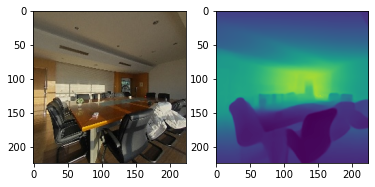

==========729==========
inst: Turn left to the door and leave the conference room. After you go out, turn left next to the black chair. Go on in the hallway, past the blue cart, and then past the square carton. When you see two chairs in front of you, turn left into the door and get to the storage room. 
sub: Turn left to the door
and leave the conference room
After you go out
turn left next to the black chair
Go on in the hallway, past the blue cart
and then past the square carton
When you see two chairs in front of you
turn left into the door
and get to the storage room
/root/autodl-tmp/realscene/rgb-vlntj/val/2326.jpg /root/autodl-tmp/realscene/depth-vlntj/val/2326.png


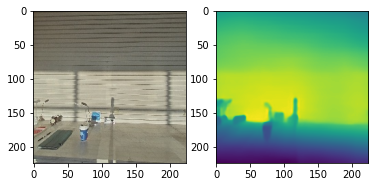

In [9]:
import matplotlib.pyplot as plt
# vision train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/realscene/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/realscene/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/val/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/val/*.png")))
# text train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/realscene/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/realscene/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/val/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/val/*.txt")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
assert len(text_files)==len(sub_files)
for _ in range(10):
    idx = random.randint(0, len(rgb_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    # print(np.array(depth).max())

In [ ]:
raw_data_path = "/root/autodl-tmp/r2r/"
dataset_path = "/root/autodl-tmp/r2r/tjark_r2r_all.json"
new_data_path = "/root/autodl-tmp/r2r_split/"
os.makedirs(new_data_path, exist_ok=True)
with open(dataset_path, "r") as f:
    tjark_r2r = json.loads(f.read())

In [ ]:
insts = []
for v in tjark_r2r:
    if v["scan"]=="TJARKmeeting603":
        print(v)
        insts.append(v["instructions"][0])

In [ ]:
min_len = 100000000000
for v in insts:
    if len(v)<min_len:
        min_len = len(v)
        print(v)

In [ ]:

dep = Image.open("/root/autodl-tmp/r2r_split/399/depth/3_3.png")
dep = np.array(dep).astype(float)/10000.0
dep = np.clip(dep, 0, 1)
dep = np.round(dep*255).astype(np.uint8)
dep = Image.fromarray(dep)
dep.save("tmp.jpg")

In [ ]:
dep.max()

In [ ]:
dep

In [ ]:
all_eval = {}
import random
for i in range(250):
    seed = random.randint(0,200000)
    os.system("cd /root/autodl-tmp; python run.py --run-type eval --exp-config evoenc/config/evoenc_realscene.yaml TASK_CONFIG.SEED {}".format(seed))
    with open("/root/autodl-tmp/data/checkpoints/evoenc_p2/evals/stats_ckpt_0_realscene.json", "r") as f:
        now_eval = json.loads(f.read())
    all_eval[seed] = now_eval
with open("all_eval.json", "w") as f:
    f.write(json.dumps(all_eval, indent=2))

In [ ]:
import json
with open("all_eval.json", "r") as f:
    all_eval = json.loads(f.read())
min_loss_rec = [100000, {}]
min_loss_mean = [100000, {}]
max_acc_inner = [-1, {}]
max_acc_outer = [-1, {}]
for v in all_eval:
    if v["losses"]["loss_rec"]<min_loss_rec[0]:
        min_loss_rec = [v["losses"]["loss_rec"], v]
    if v["losses"]["loss_mean"]<min_loss_mean[0]:
        min_loss_mean = [v["losses"]["loss_mean"], v]
    if v["accuracy"]["inner_v"]>max_acc_inner[0]:
        max_acc_inner = [v["accuracy"]["inner_v"], v]
    if v["accuracy"]["outer"]>max_acc_outer[0]:
        max_acc_outer = [v["accuracy"]["outer"], v]

In [6]:
len(train_indicies)

4386